<h1 style = "font-size:3rem;color:darkcyan"> Implementing variational autoencoders</h1>

Implementing an deep convoluational variational autoencoder class with mirrored encoder and decoder components. 

Adding: 
- bottleneck with normal distriution
- updated loss:
     - combined loss function
     - Reconstruction loss 
     - KL loss 
     
<i>Based on the work of Valerio Velardo.</i>

In [1]:
# importing libraries
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, ReLU, \
BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, \
Activation, Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

from tensorflow.keras.datasets import mnist

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [30]:
class VAE:
    
    def __init__(self, 
                input_shape,
                conv_filters,
                conv_kernels,
                conv_strides,
                latent_space_dim):
        
        self.input_shape = input_shape 
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim
        self.alpha = 1000
        
        self.encoder = None
        self.decoder = None
        self.model = None
        
        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None
        
        self._build()
        
    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()
    
    def compile(self, learning_rate = 0.0001):
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, 
                           loss = self._calculate_combined_loss,
                           )
    
    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train, 
                      x_train,
                      batch_size = batch_size,
                      epochs = num_epochs,
                      shuffle = True)
        
    def save(self, save_folder='.'):
        self._create_folder_if_needed(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)
    
    @classmethod
    def load(cls, save_folder='.'):
        parameters_path = os.path.join(save_folder, 'parameters.pkl')
        with open(parameters_path, 'rb') as f:
            parameters = pickle.load(f)
        # make autoencoder object
        autoencoder = VAE(*parameters)
        # load weights
        weights_path = os.path.join(save_folder, 'weights.h5')
        autoencoder.model.load_weights(weights_path)
        return autoencoder

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_representations = self.decoder.predict(latent_representations)
        return reconstructed_representations, latent_representations
        
    def _calculate_combined_loss(self,y_target, y_predicted):
        reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = self._calculate_kl_loss(y_target, y_predicted)
        combined_loss = self.alpha * reconstruction_loss + kl_loss
        return combined_loss
    
    def _calculate_reconstruction_loss(self, y_target, y_predicted):
        error = y_target - y_predicted
        reconstruction_loss = K.mean(K.square(error), axis = [1, 2, 3])
        return reconstruction_loss
    
    def _calculate_kl_loss(self, y_target, y_predicted):
        kl_loss = - 0.5 * K.sum(1 + self.log_variance - K.square(self.mu) - 
                                K.exp(self.log_variance), axis = 1)
        return kl_loss
    
    def _load_weights(self, weights_path):
        self.model.load_weights(weights_path)
    
    def _create_folder_if_needed(self, folder_name):
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
            
    def _save_parameters(self, folder_name):
        parameters = [
            self.input_shape, 
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(folder_name, 'parameters.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(parameters, f)
            
    def _save_weights(self, folder_name):
        save_path = os.path.join(folder_name, 'weights.h5')
        self.model.save_weights(save_path)
        
    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder() 
        
    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        self._model_input = encoder_input
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self.encoder = Model(encoder_input, bottleneck, name = 'encoder')
        
    def _add_encoder_input(self):
        return Input(shape = self.input_shape, name = 'encoder_input')
    
    def _add_conv_layers(self, encoder_input):
        layer_graph = encoder_input
        for i in range(self._num_conv_layers):
            layer_graph = self._add_conv_layer(i, layer_graph)
        return layer_graph
    
    def _add_conv_layer(self, layer_index, layer_graph):
        # conv2D + ReLu + batch normalization
        
        current_layer = layer_index + 1
        conv_layer = Conv2D(
            filters = self.conv_filters[layer_index],
            kernel_size = self.conv_kernels[layer_index],
            strides = self.conv_strides[layer_index],
            padding = 'same',
            name = f'encoder_conv_layer_{current_layer}'
        )
        
        layer_graph = conv_layer(layer_graph)
        layer_graph = ReLU(name=f'encoder_relu_{current_layer}')(layer_graph)
        layer_graph = BatchNormalization(name=f'encoder_bn_{current_layer}')(layer_graph)
        
        return layer_graph
    
    def _add_bottleneck(self, layer_graph): 
        # save shape for decoding
        self._shape_before_bottleneck = K.int_shape(layer_graph)[1:]
        
        # flatten data and add bottleneck with Gaussian sampling
        layer_graph = Flatten()(layer_graph)
        
        # create two branches of dense layers, one for the mean vector, one for log variance vector:
        self.mu = Dense(self.latent_space_dim, name = 'mu')(layer_graph)
        self.log_variance = Dense(self.latent_space_dim, 
                                  name = 'log_variance')(layer_graph)
        
        def sample_point_from_normal_distribution(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape = K.shape(self.mu), 
                                      mean = 0., 
                                      stddev = 1.)
            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            return sampled_point
            
        # merge two layers (wrapping function in graph using Lambda)
        layer_graph = Lambda(sample_point_from_normal_distribution, 
                             name = 'encoder_output')([self.mu, self.log_variance])
        
        return layer_graph
    
    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name = 'decoder')

    def _add_decoder_input(self):
        return Input(shape = self.latent_space_dim, name = 'decoder_input')
    
    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck)
        return Dense(num_neurons, name = 'decoder_dense')(decoder_input)
       
    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)
    
    def _add_conv_transpose_layers(self, layer_graph):
        for i in reversed(range(1, self._num_conv_layers)): # ignore input layer
            layer_graph = self._add_conv_transpose_layer(i, layer_graph)
        return layer_graph
    
    def _add_conv_transpose_layer(self, layer_index, layer_graph):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters = self.conv_filters[layer_index],
            kernel_size = self.conv_kernels[layer_index],
            strides = self.conv_strides[layer_index],
            padding = 'same',
            name = f'decoder_conv_transpose_layer_{layer_num}'
        )
        
        layer_graph = conv_transpose_layer(layer_graph)
        layer_graph = ReLU(name = f'decoder_ReLU_{layer_num}')(layer_graph)
        layer_graph = BatchNormalization(name = f'decoder_bn_{layer_num}')(layer_graph)
        
        return layer_graph
    
    def _add_decoder_output(self, layer_graph):
        conv_transpose_layer = Conv2DTranspose(
            filters = 1,
            kernel_size = self.conv_kernels[0],
            strides = self.conv_strides[0],
            padding = 'same',
            name = f'decoder_conv_transpose_layer_{self._num_conv_layers}'
        ) 
        
        layer_graph = conv_transpose_layer(layer_graph)
        output_layer = Activation('sigmoid', name = 'output_sigmoid_layer')(layer_graph)
        return output_layer
        
    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name = 'autoencoder')
            

# Create autoencoder instance

In [31]:
vae = VAE(
    input_shape = (28,28,1),
    conv_filters = (32,64,64,64),
    conv_kernels = (3,3,3,3),
    conv_strides = (1,2,2,1),
    latent_space_dim = 2
)

In [16]:
vae.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 encoder_relu_1 (ReLU)          (None, 28, 28, 32)   0           ['encoder_conv_layer_1[0][0]']   
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 28, 28, 32)  128         ['encoder_relu_1[0][0]']         
 on)                                                                                        

# Import data and train model

In [17]:
# import dataset

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # normalize and add dimension
    x_train = x_train.astype('float32') / 255
    x_train = x_train.reshape(x_train.shape + (1,))
    
    x_test = x_test.astype('float32') / 255
    x_test = x_test.reshape(x_test.shape + (1,))
    
    return x_train, y_train, x_test, y_test
    
x_train, _, _, _ = load_mnist()

In [32]:
# train model
learning_rate = 0.0005
batch_size = 32
epochs = 5

vae.compile(learning_rate)
vae.train(x_train[:10000], batch_size, epochs)

Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 15s 1ms/sample - loss: 89.9258
Epoch 2/5
10000/10000 [==============================] - 11s 1ms/sample - loss: 66.4129
Epoch 3/5
10000/10000 [==============================] - 12s 1ms/sample - loss: 60.3478
Epoch 4/5
10000/10000 [==============================] - 10s 1ms/sample - loss: 57.6600
Epoch 5/5
10000/10000 [==============================] - 12s 1ms/sample - loss: 54.8403


# Saving and Loading the autoencoder model


In [33]:
# Save model
vae.save('model_VAE')

In [34]:
# load model
vae2 = VAE.load('model_VAE')

In [35]:
vae2.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 encoder_relu_1 (ReLU)          (None, 28, 28, 32)   0           ['encoder_conv_layer_1[0][0]']   
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 28, 28, 32)  128         ['encoder_relu_1[0][0]']         
 on)                                                                                        

# Analysis

In [36]:
# predefined methods:
def select_images(images, labels, num_images=10):
    sample_images_index = np.random.choice(range(len(images)), num_images)
    sample_images = images[sample_images_index]
    sample_labels = labels[sample_images_index]
    return sample_images, sample_labels

def plot_reconstructed_images(images, reconstructed_images):
    fig = plt.figure(figsize=(15, 3))
    num_images = len(images)
    for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
        image = image.squeeze()
        ax = fig.add_subplot(2, num_images, i + 1)
        ax.axis("off")
        ax.imshow(image, cmap="gray_r")
        reconstructed_image = reconstructed_image.squeeze()
        ax = fig.add_subplot(2, num_images, i + num_images + 1)
        ax.axis("off")
        ax.imshow(reconstructed_image, cmap="gray_r")
    plt.show()

C:\Users\helme\anaconda3\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


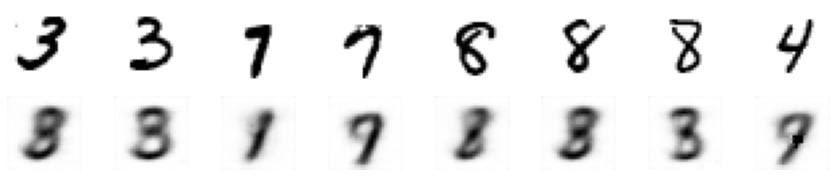

In [37]:
#vae = vae.load('model_VAE')
x_train, y_train, x_test, y_test = load_mnist()

num_sample_images_to_show = 8
sample_images, sample_labels = select_images(x_test, y_test, num_sample_images_to_show)

reconstructed_images, _ = vae.reconstruct(sample_images)

plot_reconstructed_images(sample_images, reconstructed_images)

# Visualizing the latent space


In [149]:
def plot_images_in_latent_space(latent_representations, sample_label):
    plt.figure(figsize=(10,10))
    plt.title('Latent Space Plot')
    plt.scatter(latent_representations[:, 0],
               latent_representations[:, 1],
               cmap = 'rainbow',
               c = sample_labels,
               alpha = 0.5,
               s = 2)
    plt.colorbar()
    plt.show()

188/188 [==============================] - 1s 6ms/step


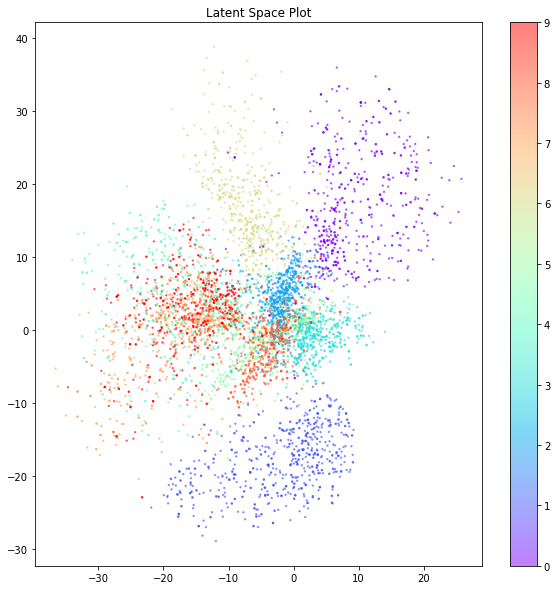

In [150]:
num_sample_images_to_show = 6000
sample_images, sample_labels = select_images(x_test, y_test, num_sample_images_to_show)
_, latent_representations = autoencoder.reconstruct(sample_images)

plot_images_in_latent_space(latent_representations, sample_labels)

# Problems :
- Plot is not symmetrical around the origin (no point of reference making it hard to sample points for generation)
- Labels are not evenly disctributed on the latent space (some are more spread out than others -> probability is skewed towards some digits)
- Gaps between labels (decreased quality)
